Use the initial condition prescribed in example here: http://databookuw.com/databook.pdf#page=93

Apply different transformations like Fourier, wavelets, and other interesting things we can try from literature to make this better.

In [2]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [3]:
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.rc("text", usetex=True)

In [4]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
K = T*10**3 + 1                 # Temporal grid size.
t = np.linspace(0, T, K)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001


In [5]:
x_all.shape

(129,)

In [6]:
# Construct the full-order state matrix A.
dx2inv = 1 / dx**2
diags = np.array([1, -2, 1]) * dx2inv
A = sparse.diags(diags, [-1, 0, 1], (n, n))

In [7]:
# Construct the full-order input matrix B.
B = np.zeros_like(x)
B[0], B[-1] = dx2inv, dx2inv
B.shape # doubt how is B approximating the original PDE correctly????

(127,)

In [8]:
alpha = 100

wave_lb = np.floor((L/2 - L/8)/dx).astype(int)
wave_ub = np.floor((L/2 + L/8)/dx).astype(int)

print("Index for Wave Begin and End is {}, {}".format(wave_lb, wave_ub))

q0 = np.zeros(x.shape)
q0[wave_lb:wave_ub] = 1

Index for Wave Begin and End is 48, 80


In [9]:
def implicit_euler(t, q0, A):
    """Solve the system

        dq / dt = Aq(t),    q(0) = q0,

    over a uniform time domain via the implicit Euler method.

    Parameters
    ----------
    t : (k,) ndarray
        Uniform time array over which to solve the ODE.
    q0 : (n,) ndarray
        Initial condition.
    A : (n, n) ndarray
        State matrix.

    Returns
    -------
    q : (n, k) ndarray
        Solution to the ODE at time t; that is, q[:,j] is the
        computed solution corresponding to time t[j].
    """
    # Check and store dimensions.
    k = len(t)
    n = len(q0)

    assert A.shape == (n, n)

    I = np.eye(n)

    # Check that the time step is uniform.
    dt = t[1] - t[0]
    assert np.allclose(np.diff(t), dt)

    # Factor I - dt*A for quick solving at each time step.
    factored = la.lu_factor(I - dt*A)

    # Solve the problem by stepping in time.
    q = np.empty((n, k))
    q[:,0] = q0.copy()
    for j in range(1, k):
        q[:, j] = la.lu_solve(factored, q[:, j-1])

    return q

In [10]:
Q_all = implicit_euler(t, q0, A)
Q_all.shape

(127, 1001)

In [11]:
# Retain only the first k snapshots/inputs for training the ROM.
k = 100                         # Number of training snapshots.
t_train = t[:k]                 # Temporal domain for training snapshots.
Q = Q_all[:, :k]                # Observed snapshots.

In [12]:
# Estimate time derivatives (dq/dt) for each training snapshot.
Qdot_train = (Q[:, 1:] - Q[:, :-1]) / dt
Q_train = Q[:, 1:]              # Training snapshots.

print(f"shape of Q_train:\t{Q_train.shape}")
print(f"shape of Qdot_train:\t{Qdot_train.shape}")

shape of Q_train:	(127, 99)
shape of Qdot_train:	(127, 99)


In [13]:
def plot_heat_data(Z, title, ax=None):
    """Visualize temperature data in space and time."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 10, 20, 40, 80, 160, 320, 640]
    sample_columns = [0] + [2**d for d in range(10)]
    color = iter(plt.cm.viridis_r(np.linspace(.05, 1, len(sample_columns))))
    while sample_columns[-1] > Z.shape[1]:
        sample_columns.pop()
    leftBC, rightBC = [0], [0]
    for j in sample_columns:
        q_all = np.concatenate([leftBC, Z[:,j], rightBC])
        ax.plot(x_all, q_all, color=next(color), label=fr"$q(x,t_{{{j}}})$")

    ax.set_xlim(x_all[0], x_all[-1])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$q(x,t)$")
    ax.legend(loc=(1.05, .05))
    ax.set_title(title)

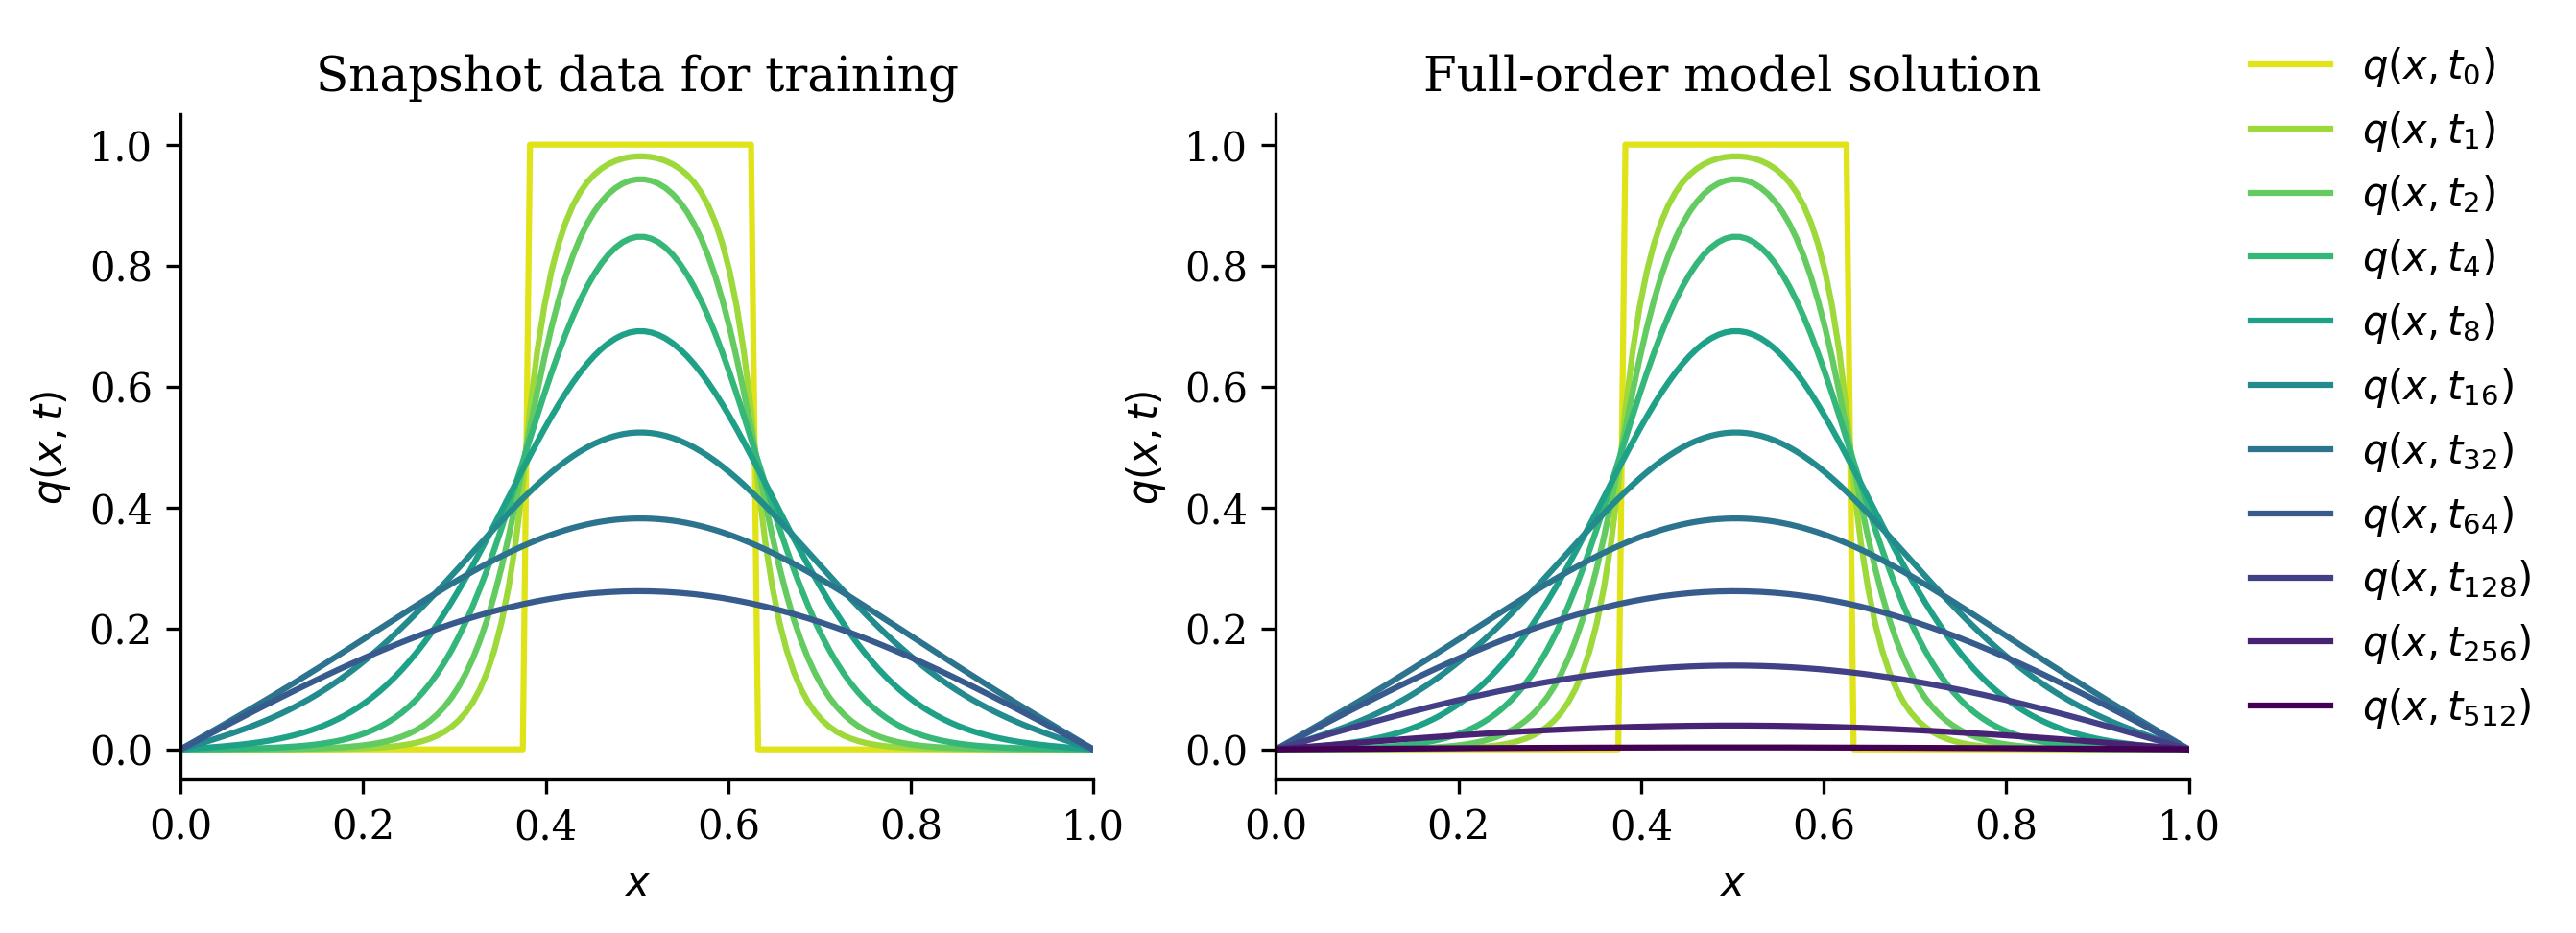

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q, "Snapshot data for training", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

In [15]:
Q.shape

(127, 100)

PODBasis
Full-order dimension    n = 127
Reduced-order dimension r = 8


(0.0, 25.0)

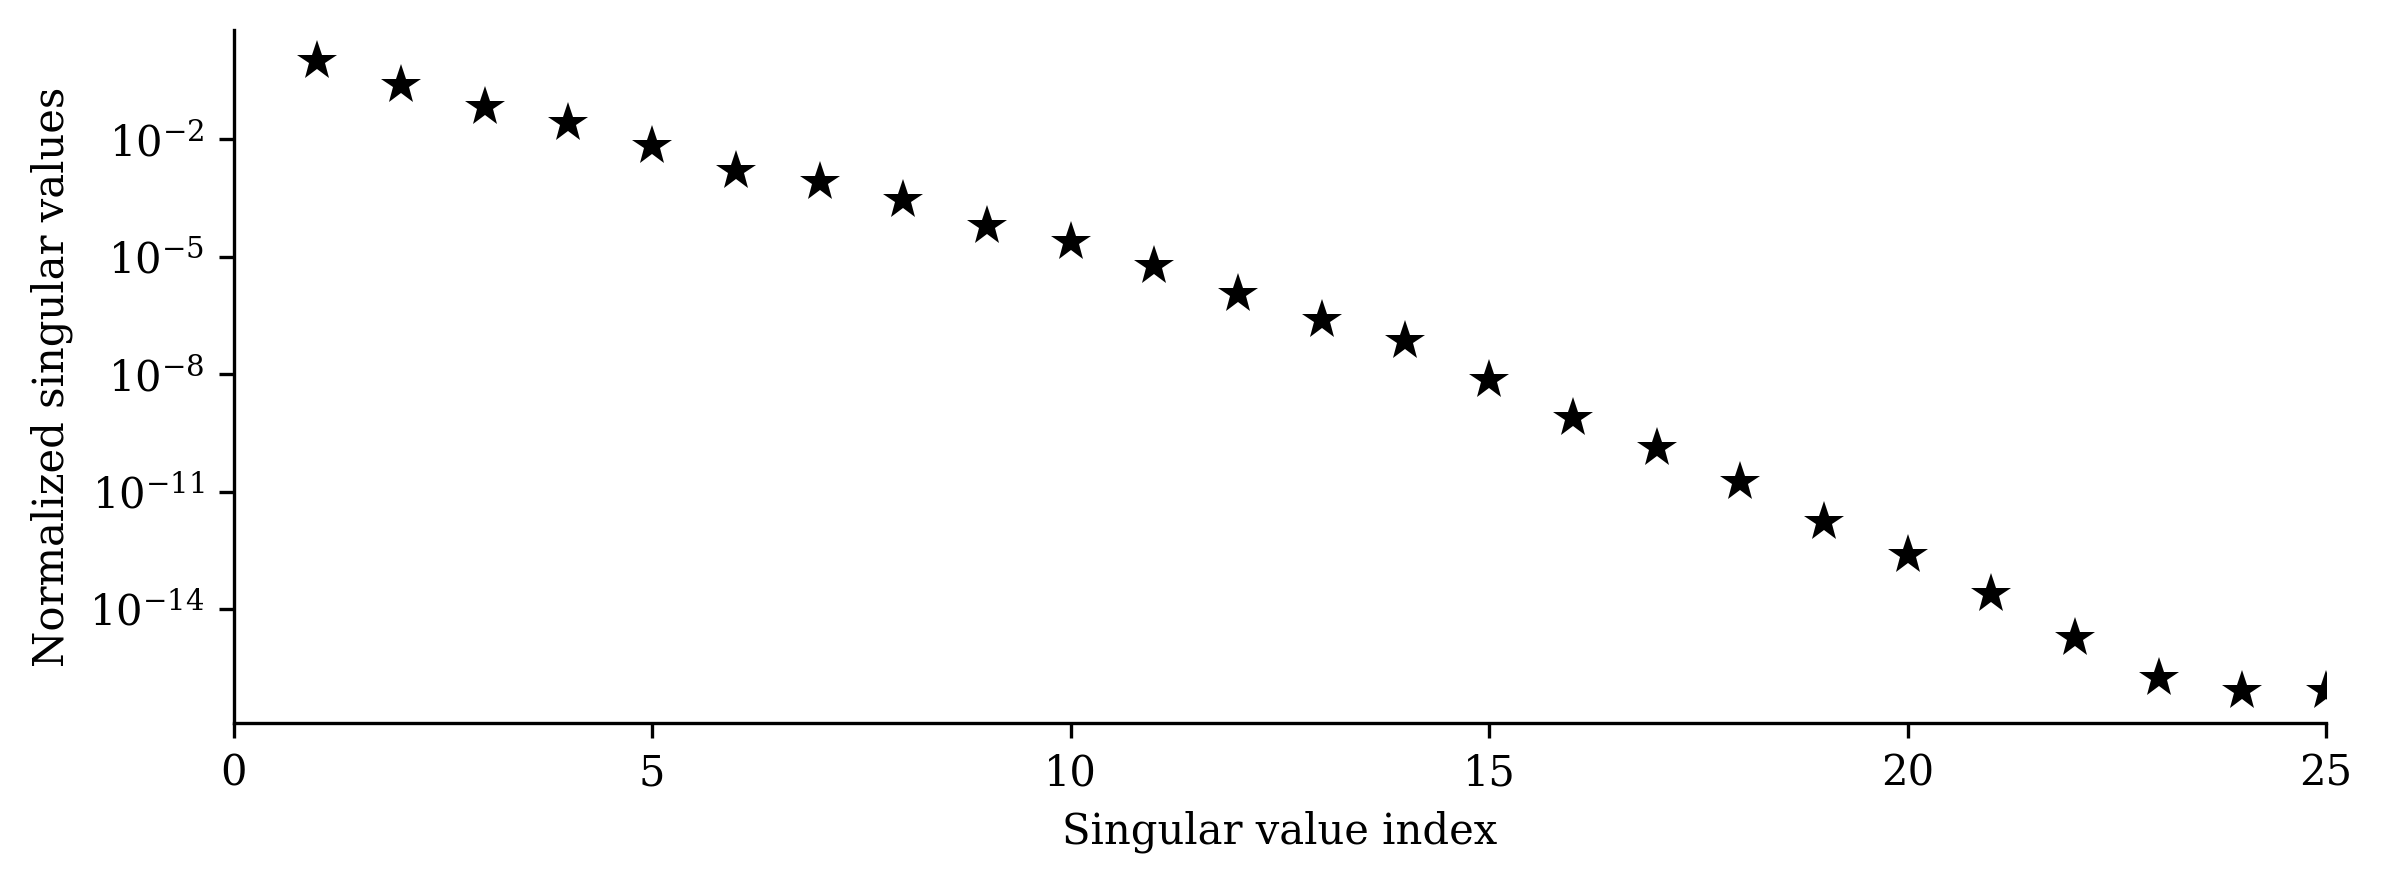

In [16]:
# Compute the POD basis, using the residual energy decay to select r.
basis = opinf.pre.PODBasis().fit(Q, residual_energy=1e-8)
print(basis)

# Check the decay of the singular values.
basis.plot_svdval_decay()
plt.xlim(0, 25)

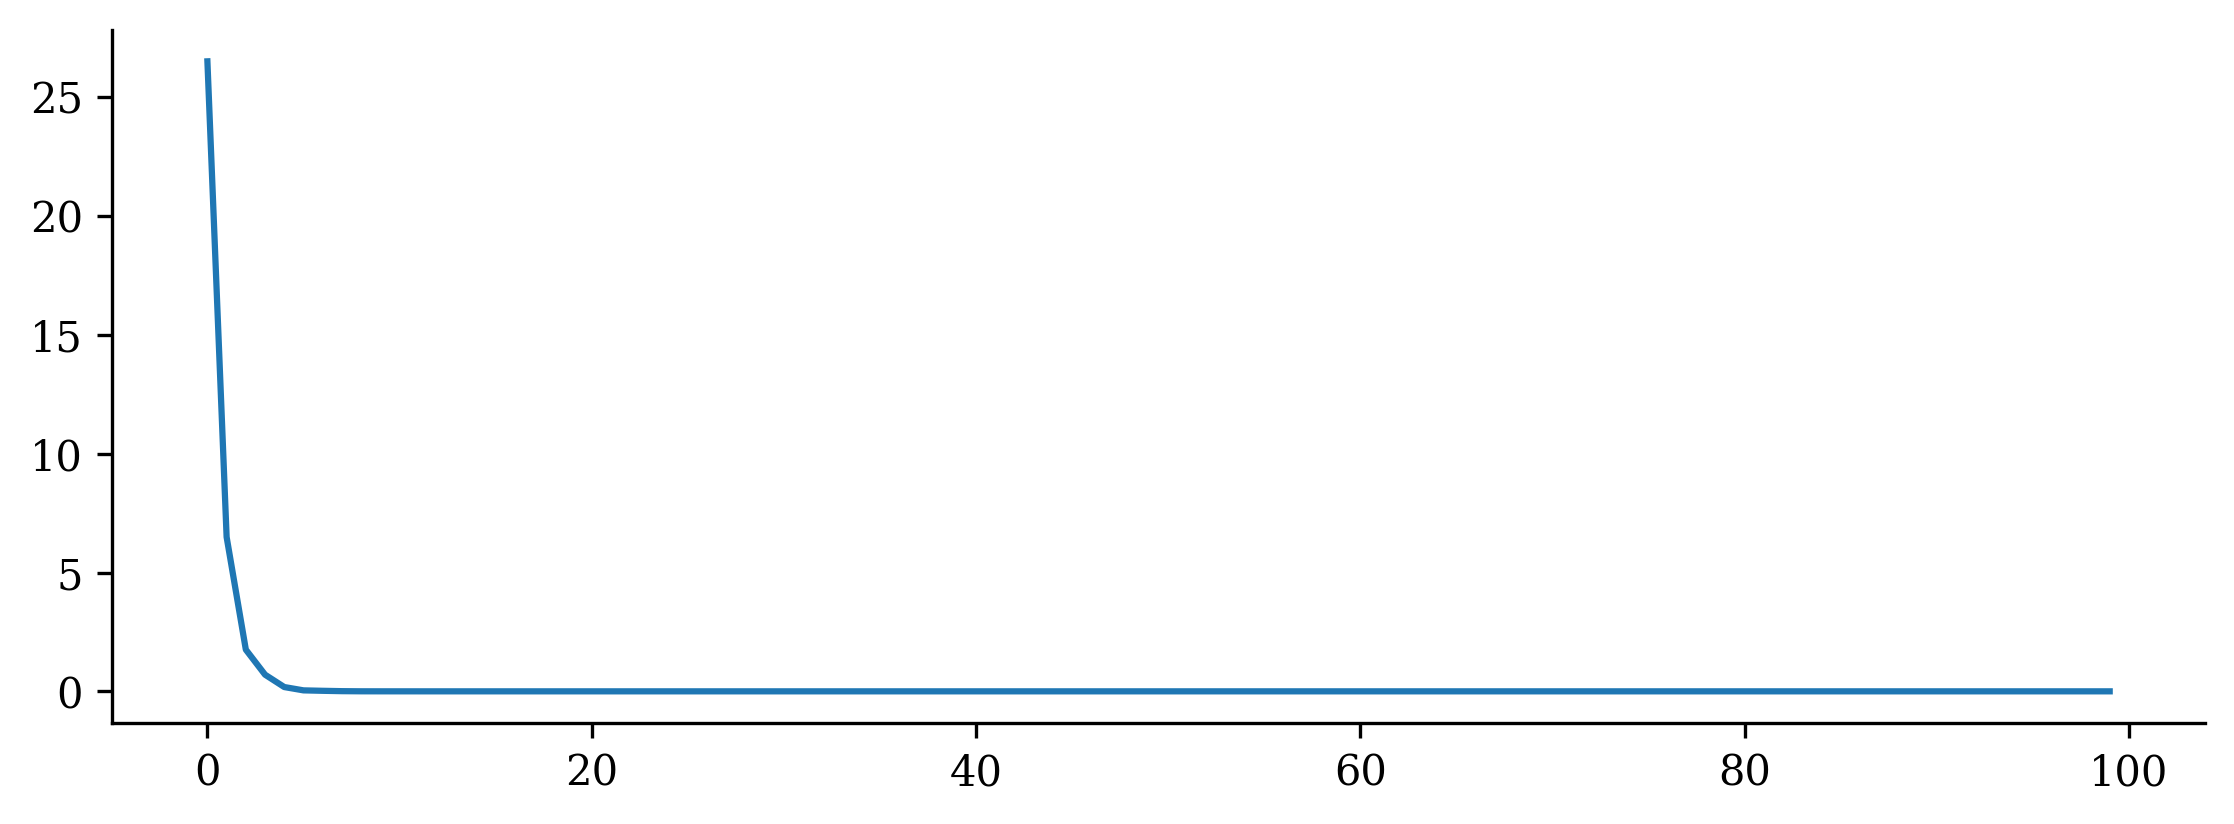

In [17]:
plt.plot(basis.svdvals)

In [18]:
rom = opinf.ContinuousOpInfROM(modelform="A")

In [19]:
rom.fit(basis=basis, states=Q_train, ddts=Qdot_train)

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 127
Reduced-order dimension r = 8

In [20]:
# Express the initial condition in the coordinates of the basis.
q0_ = basis.encode(q0)

# Solve the reduced-order model using Implicit Euler.
Q_ROM = basis.decode(implicit_euler(t, q0_, rom.A_.entries))

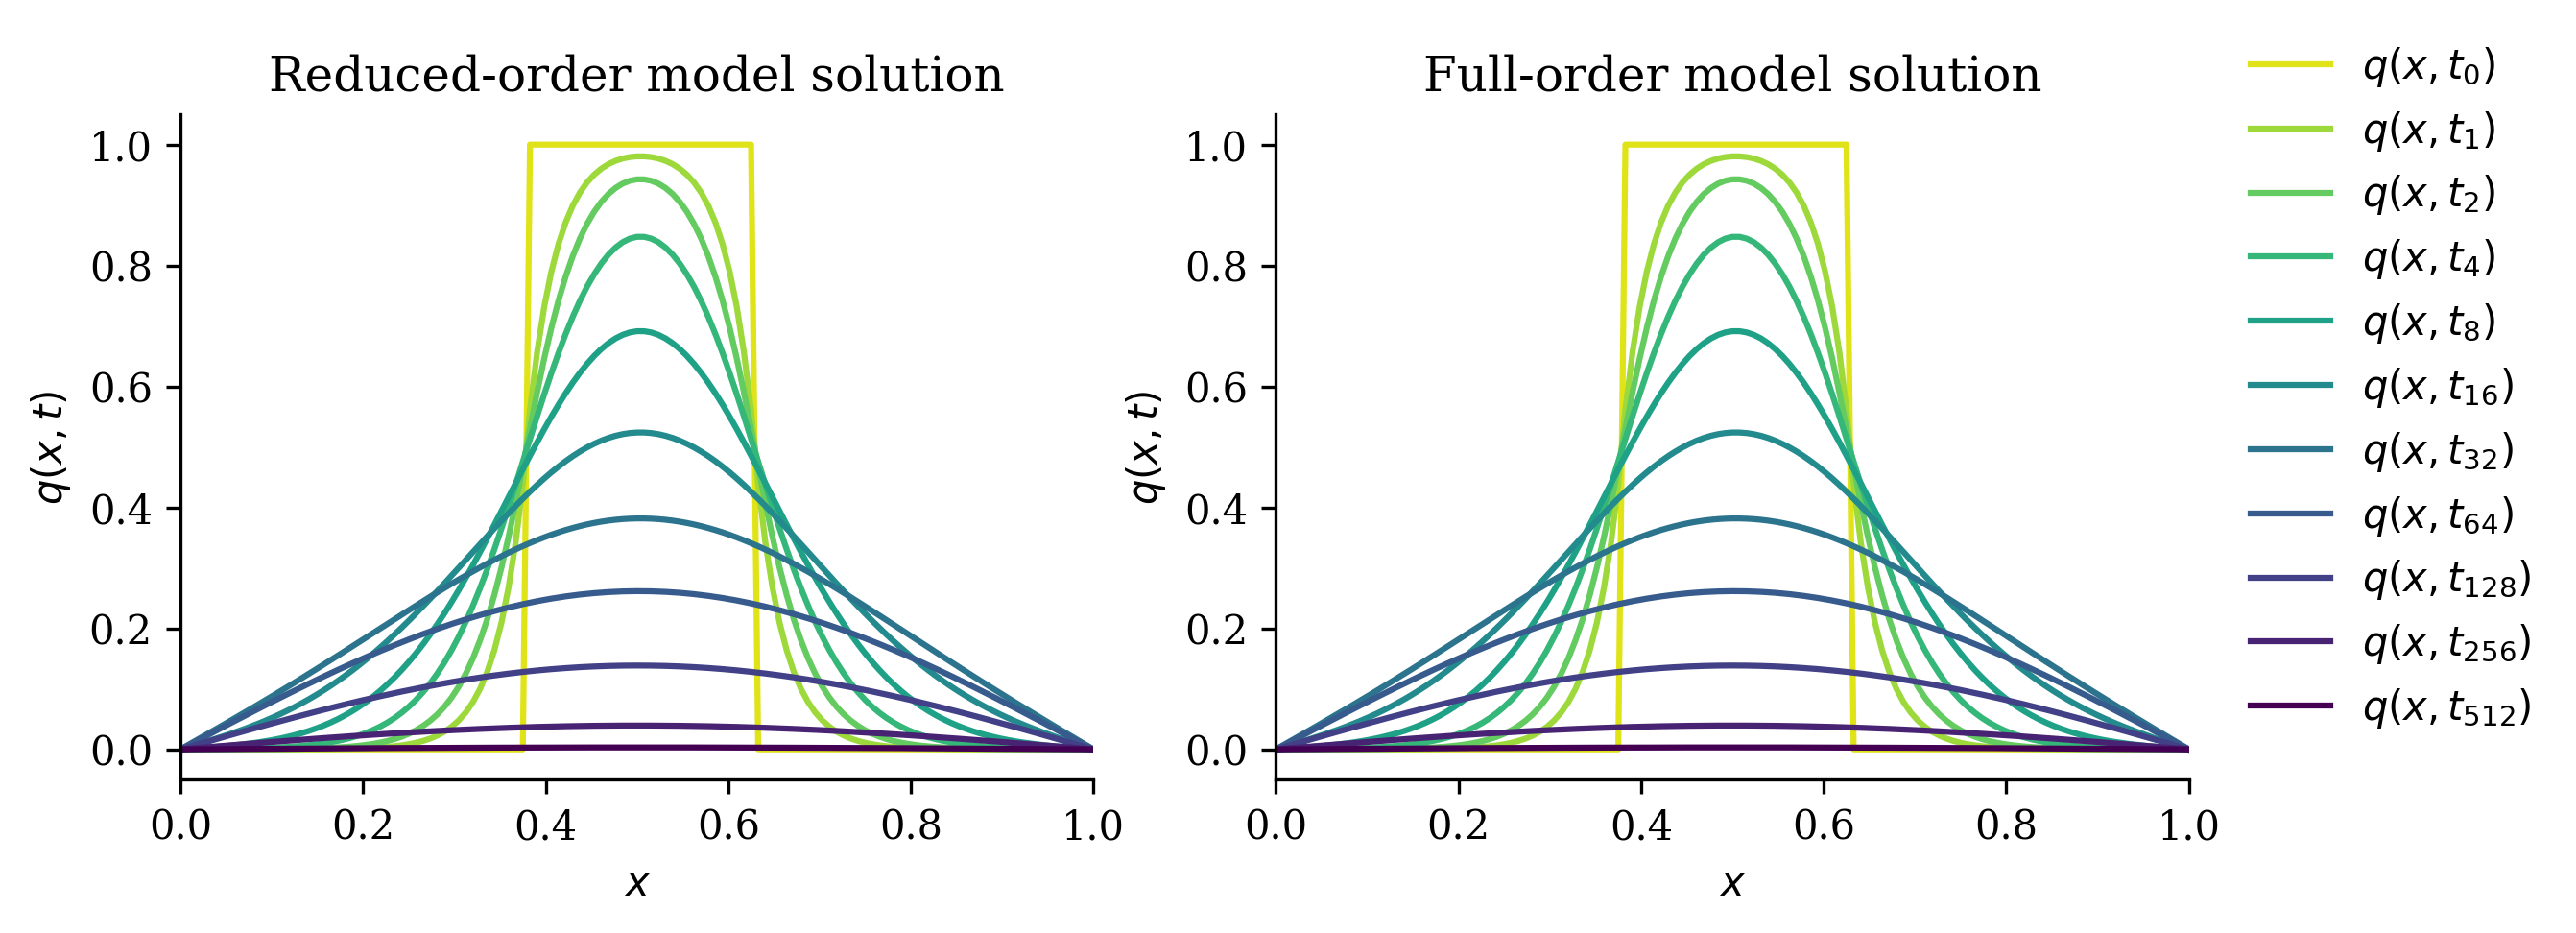

In [21]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q_ROM, "Reduced-order model solution", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

#### Fourier Transform

In [38]:
q0Hat = np.fft.fftshift(np.fft.fft(Q[:, 0]))

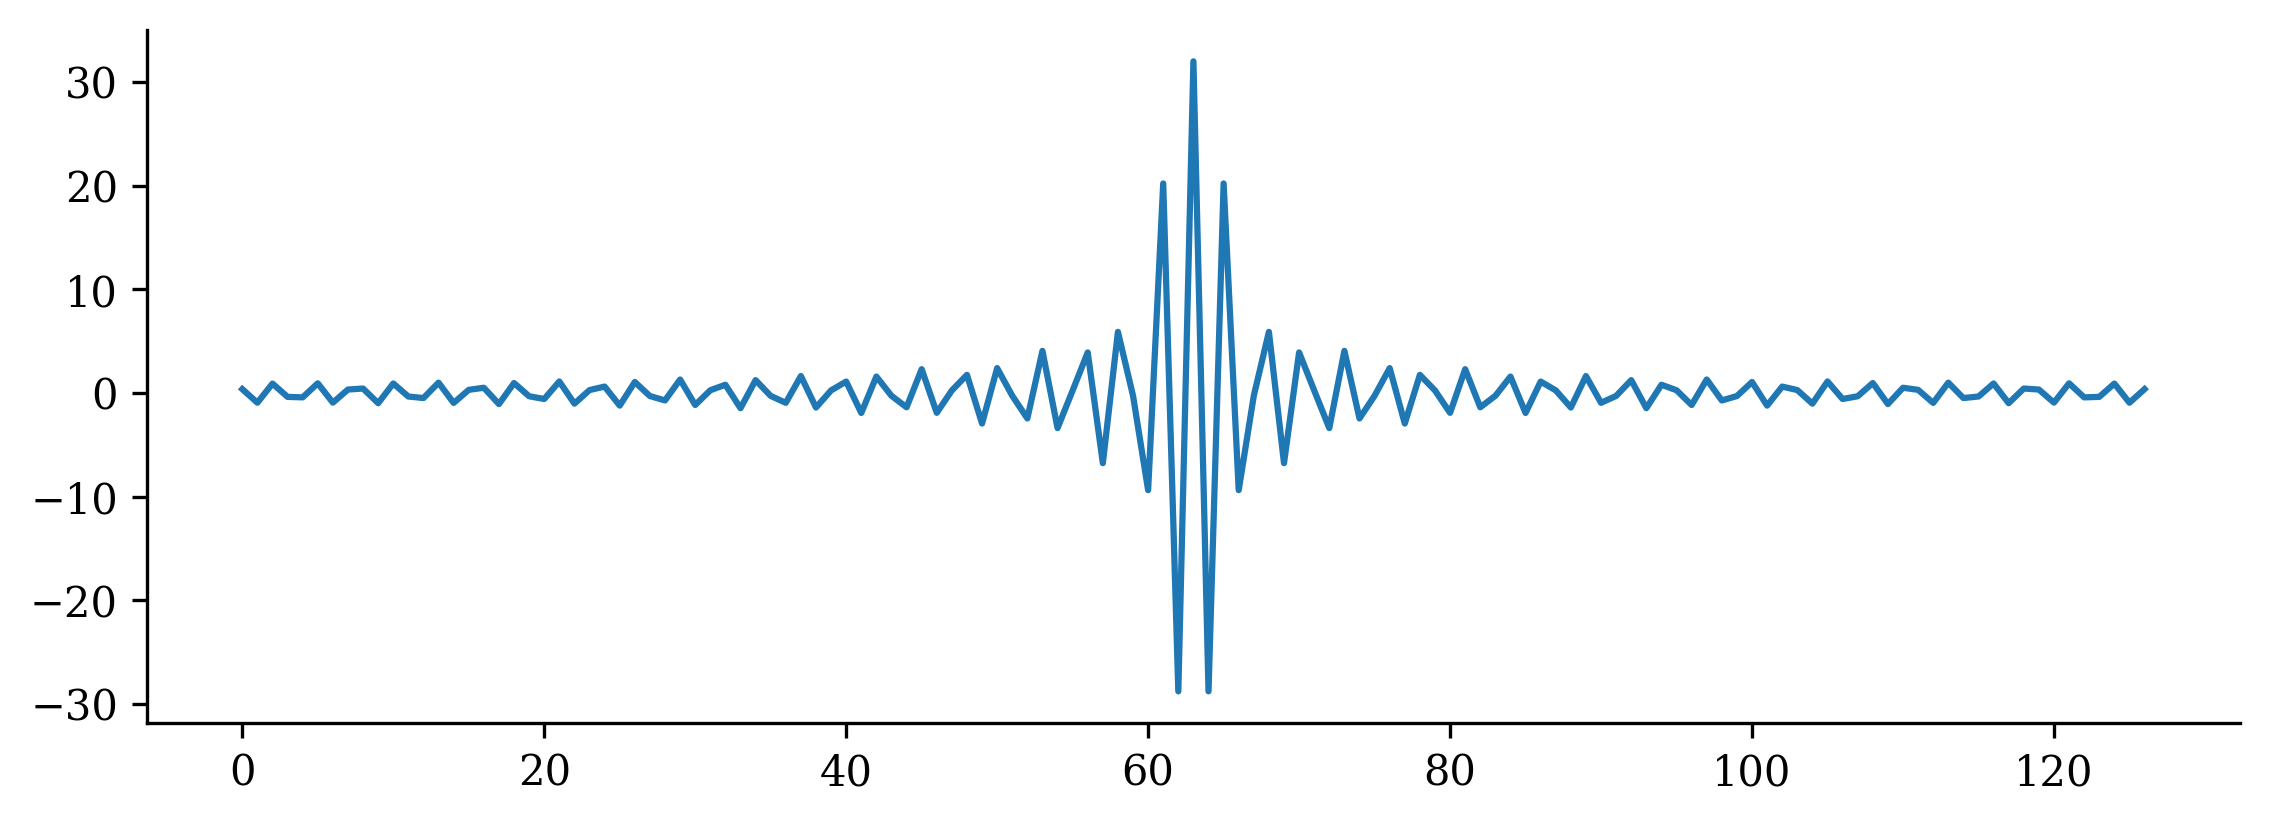

In [39]:
plt.plot(q0Hat)

In [40]:
Q_sol_hat = np.zeros(Q.shape)
Q_sol_hat[:, 0] = q0Hat
for ii in range(1, len(t_train)):
    Q_sol_hat[:, ii] = np.fft.fftshift(np.fft.fft(Q[:, ii]))

/tmp/ipykernel_2769733/1754053709.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_sol_hat[:, 0] = q0Hat
/tmp/ipykernel_2769733/1754053709.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_sol_hat[:, ii] = np.fft.fftshift(np.fft.fft(Q[:, ii]))


In [44]:
Q_sol_hat.shape

(127, 100)

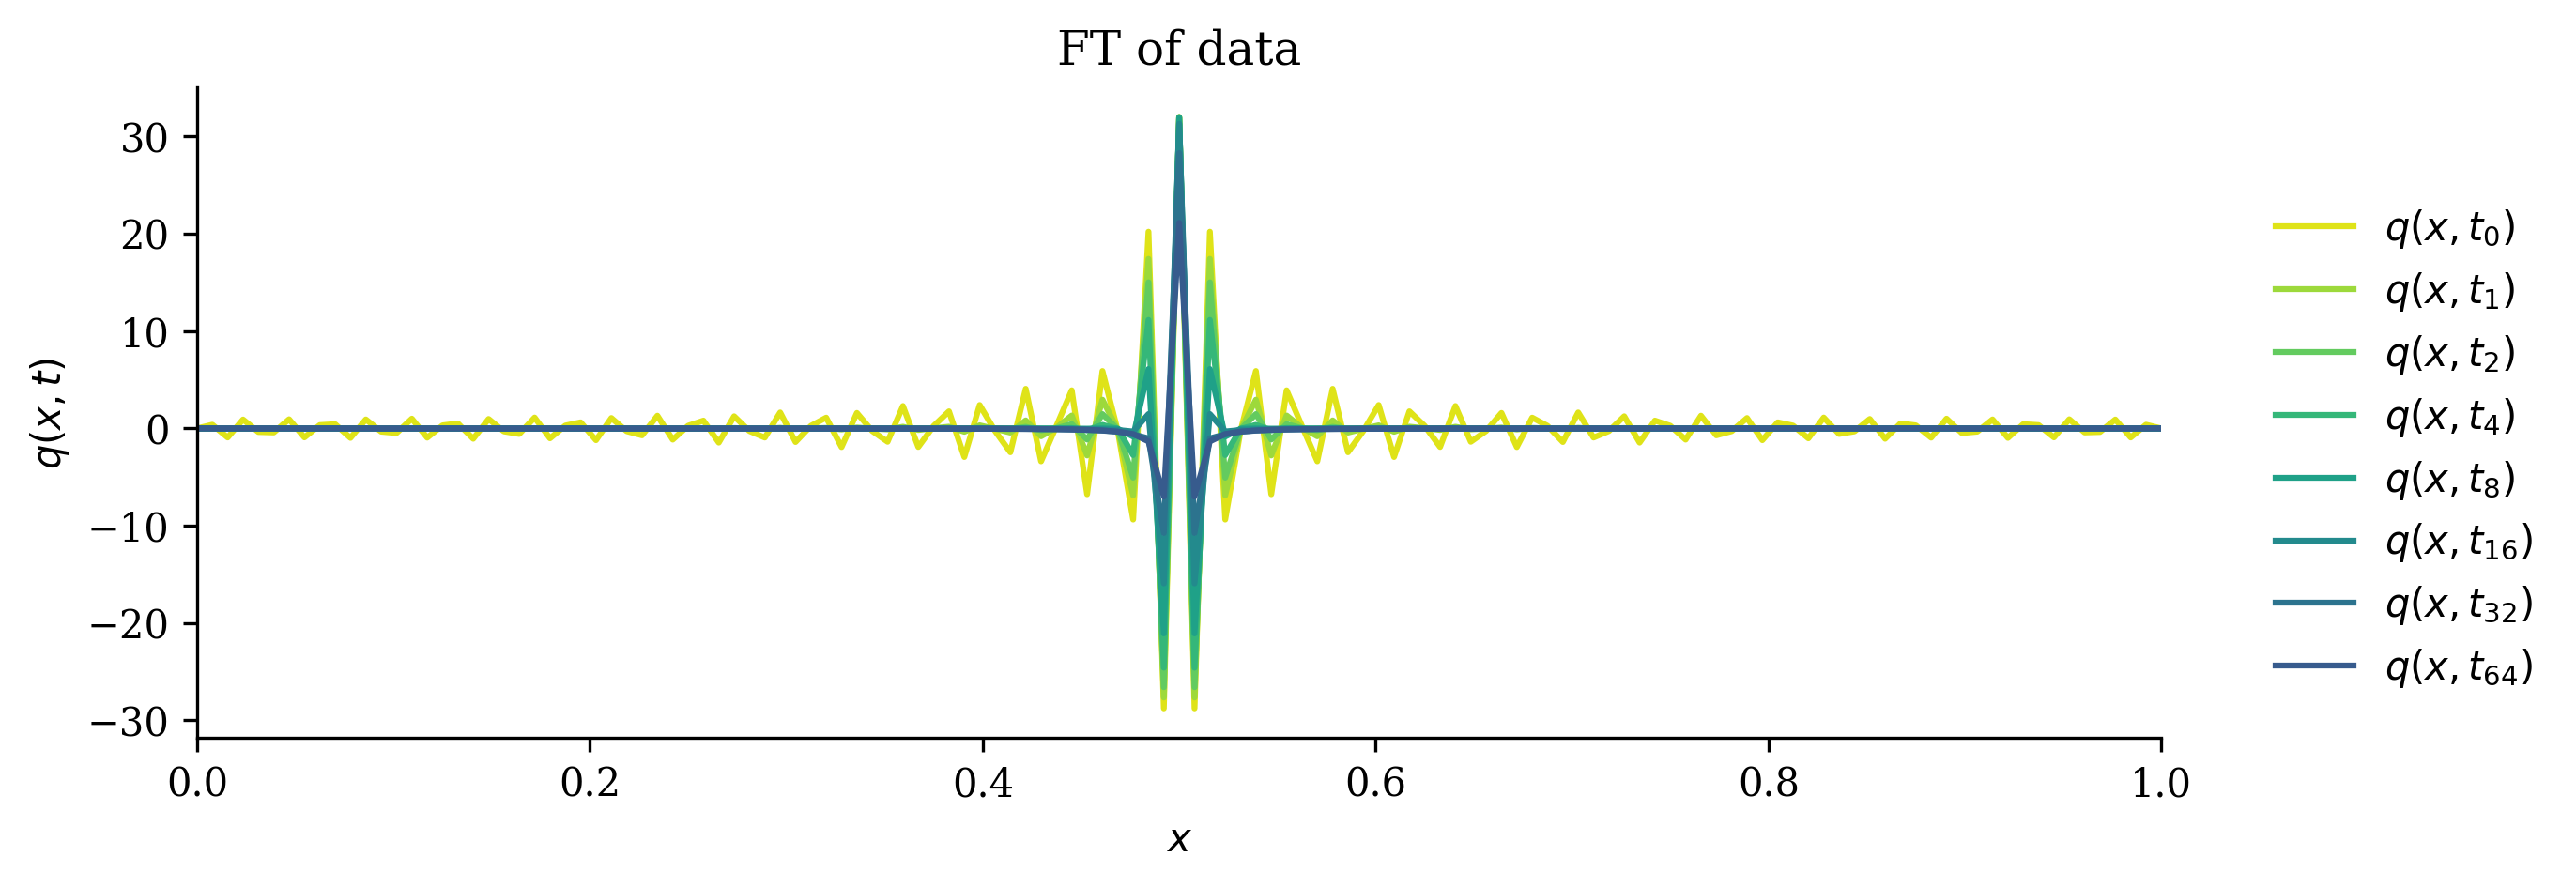

<Figure size 2700x3000 with 0 Axes>

<Figure size 3600x900 with 0 Axes>

In [41]:
plot_heat_data(Q_sol_hat, "FT of data")
plt.legend(loc=(1.05, 0.05))
plt.show()
plt.figure().set_figheight(10)
plt.figure().set_figwidth(12)

PODBasis
Full-order dimension    n = 127
Reduced-order dimension r = 7


(0.0, 25.0)

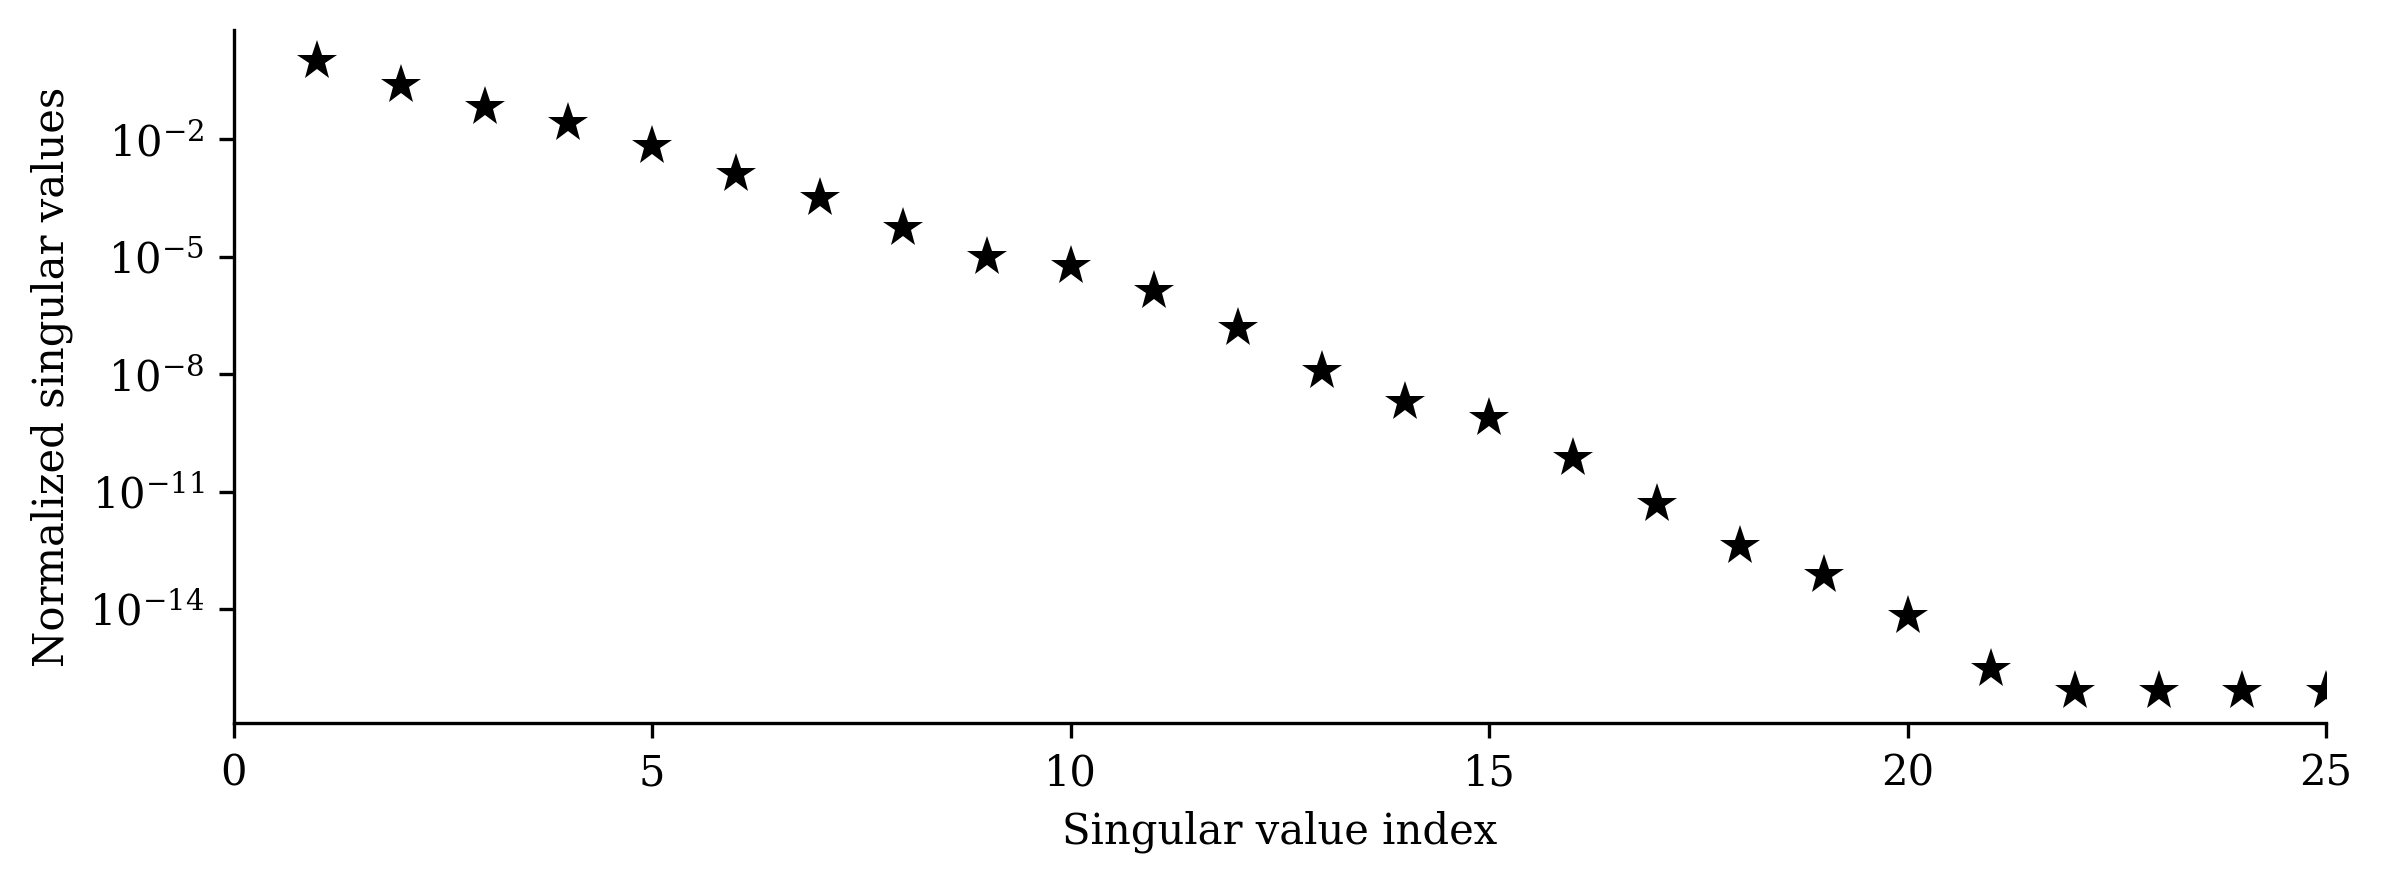

In [42]:
basis_ft = opinf.pre.PODBasis().fit(Q_sol_hat, residual_energy=1e-8)
print(basis_ft)

# Check the decay of the singular values.
basis_ft.plot_svdval_decay()
plt.xlim(0, 25)

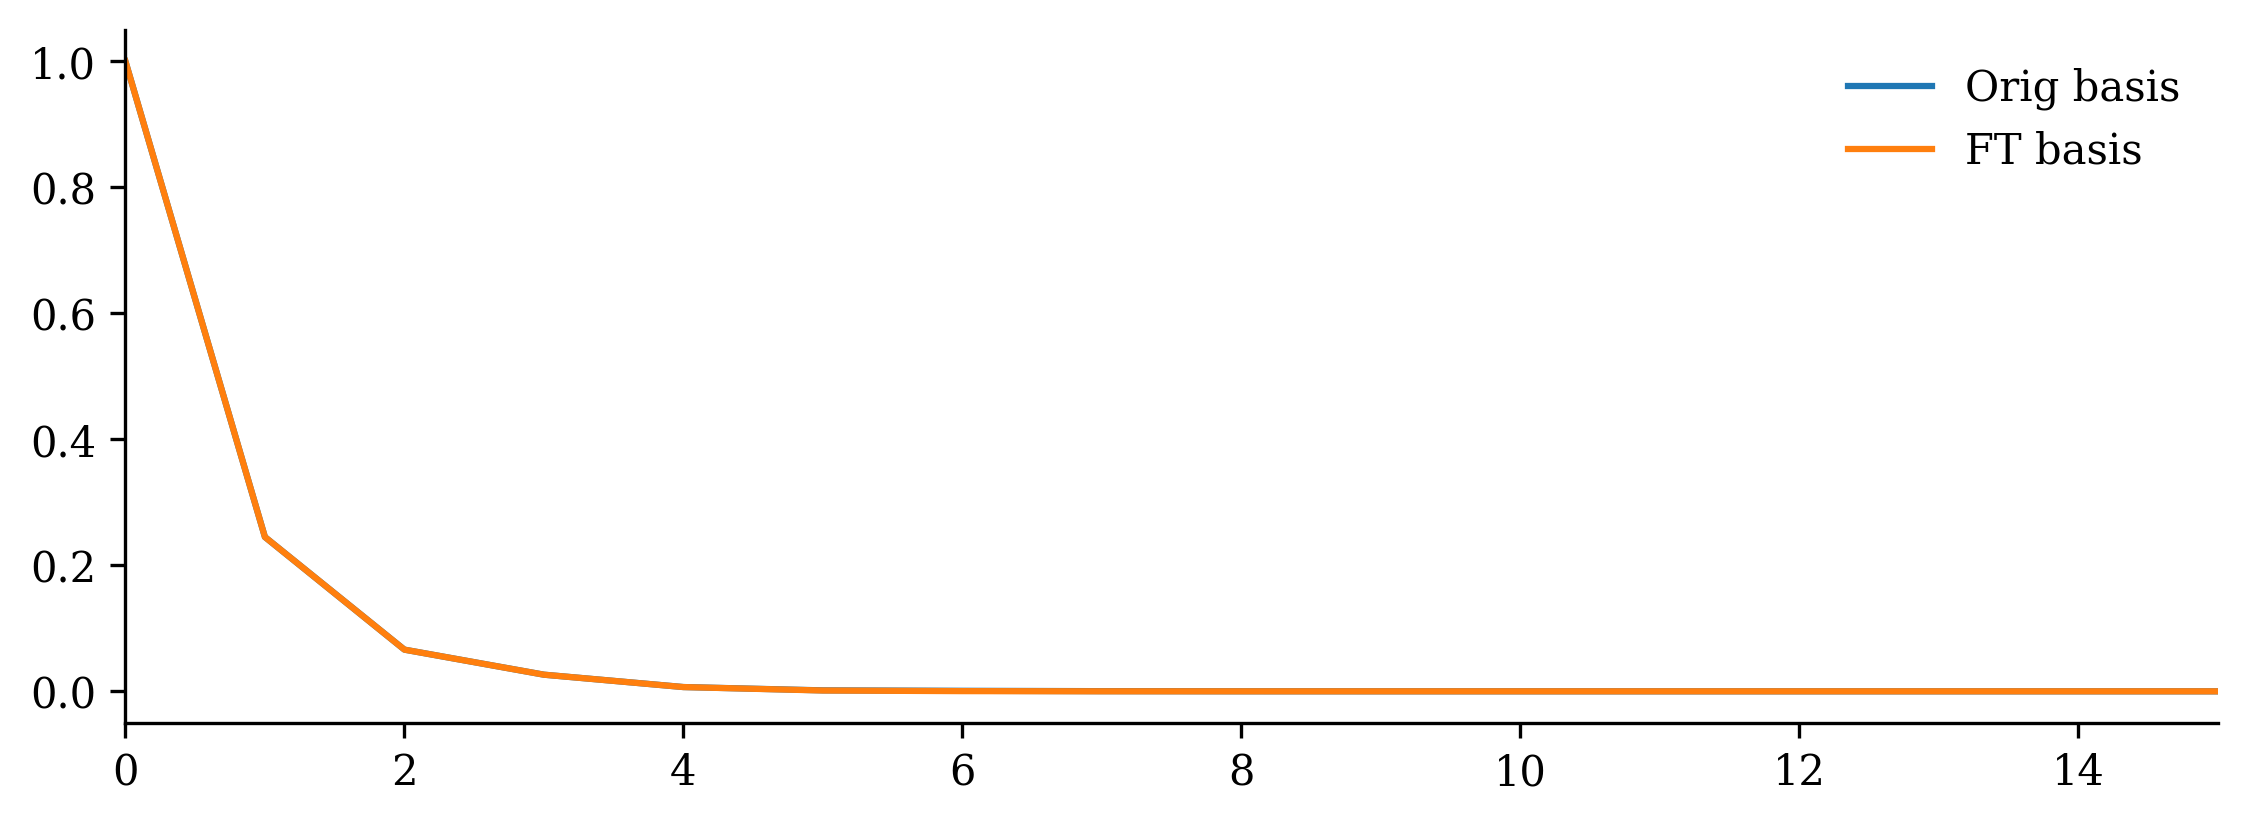

In [43]:
plt.plot(basis.svdvals/basis.svdvals[0], label="Orig basis")
plt.plot(basis_ft.svdvals/basis_ft.svdvals[0], label="FT basis")
plt.xlim(0, 15)
plt.legend()

Can we also do OpInf with Fourier transformed data, to see that we indeed recover correct solution?

Do we need this i.e. https://github.com/WarrenWeckesser/odeintw ? since MATLAB can handle complex numbers properly in `ode45` routine but it seems SciPy cannot.

In [46]:
# Estimate time derivatives (dq/dt) for each training snapshot.
Qdot_train_hat = (Q_sol_hat[:, 1:] - Q_sol_hat[:, :-1]) / dt
Q_train_hat = Q_sol_hat[:, 1:]              # Training snapshots.

# print(f"shape of Q_train:\t{Q_train.shape}")
# print(f"shape of Qdot_train:\t{Qdot_train.shape}")

In [47]:
rom_ft = opinf.ContinuousOpInfROM(modelform="A")

In [48]:
rom_ft.fit(basis=basis_ft, states=Q_train_hat, ddts=Qdot_train_hat)

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 127
Reduced-order dimension r = 7

In [49]:
# Express the initial condition in the coordinates of the basis.
q0Hat_ = basis_ft.encode(q0Hat)

# Solve the reduced-order model using Implicit Euler.
QHat_ROM = basis_ft.decode(implicit_euler(t, q0Hat_, rom_ft.A_.entries))

/tmp/ipykernel_2769733/227538083.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  q[:,0] = q0.copy()


In [52]:
QHat_ROM.shape

(127, 1001)

Hopefully, we are not incurring errors by solving in complex domain, if that's the case we should probably disregard this technique for now.

In [54]:
QHat_ROM_orig = np.zeros(QHat_ROM.shape)
QHat_ROM_orig[:, 0] = q0
for ii in range(1, QHat_ROM.shape[1]):
    QHat_ROM_orig[:, ii] = np.fft.ifft(np.fft.ifftshift(QHat_ROM[:, ii]))

/tmp/ipykernel_2769733/2559300300.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  QHat_ROM_orig[:, ii] = np.fft.ifft(np.fft.ifftshift(QHat_ROM[:, ii]))


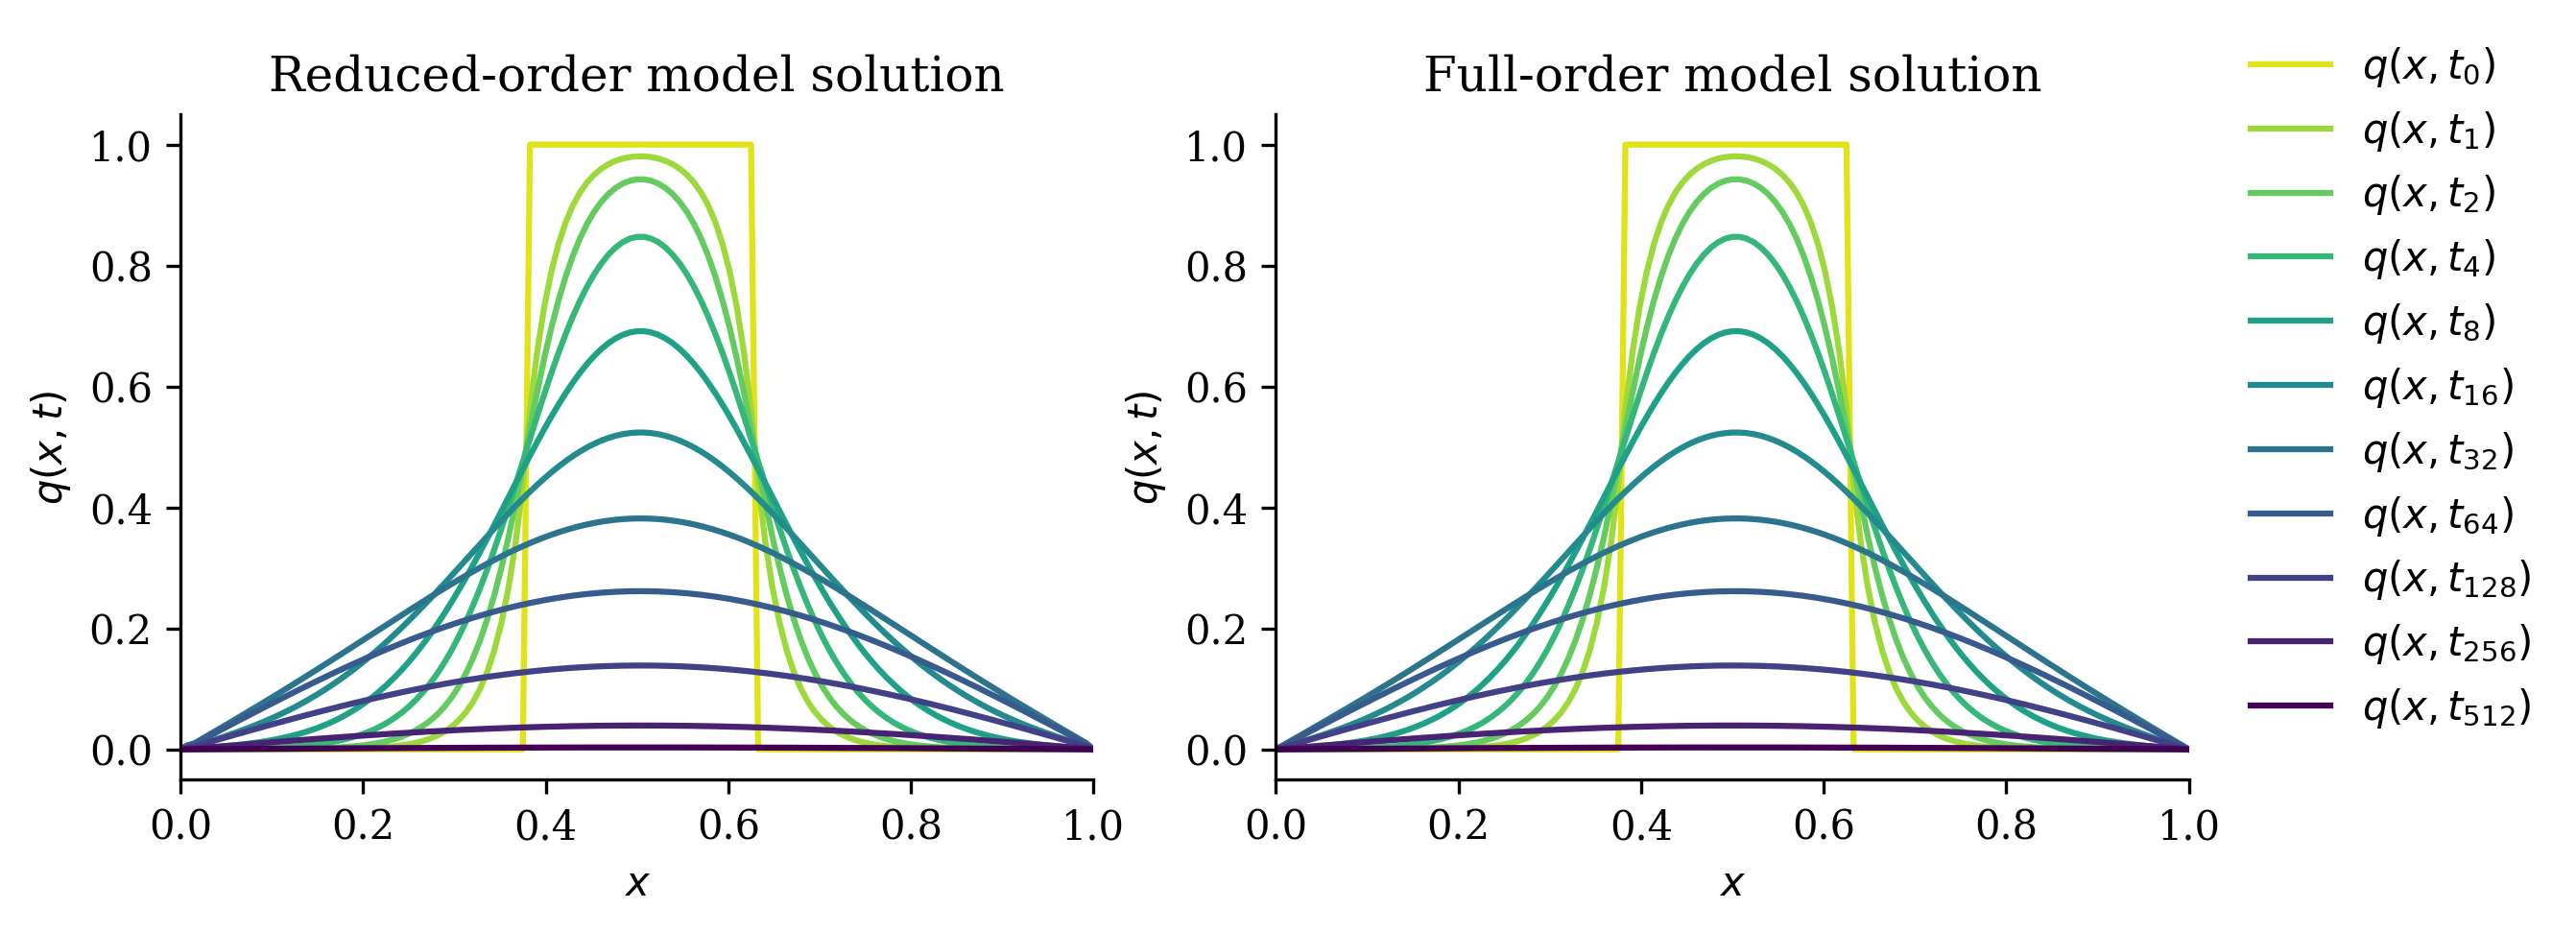

In [55]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(QHat_ROM_orig, "Reduced-order model solution", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

The above seems fairly decent! Maybe SciPy does do things correctly after all (remains to be verified)

###  STFT (Short-time Fourier Transform)

### Wavelet Decomposition?

This is a similar idea to rescaling, because wavelets contain dilation and translation factors that we apply to original basis function or "mother wavelet"

**Try to find basis with appropriately scaled data**

Scale using some form of $x/t$

This has the best chance of working if _done_ right.

In [61]:
Q.shape

(127, 100)

In [62]:
t_train.shape

(100,)